# Computing Spectral Density Subsequent Memory Effects from Scalp EEG

Here I will demonstrate the computations involved in generating spectral density subsequent memory effects from preprocessed EEG data. 

## 1. Get epoched data for encoding trials and an index of remembered & forgotten trials.
We will start by estimating power spectral density across 18 logarithmically spaced frequencies for each participant (replicating the method from Weideman & Kahana, 2021). We will also get separate dataframes for spectral density in remembered vs. forgotten trials. We will then Z-transform the spectral density estimates. 

Typically this process is done serially for all participants using a wrapper function, but to fully illustrate what the code is doing, I will show the computations being done with one participant only.

In [7]:
import All_epochs
import get_trial_power
import Ztrans_power
import mne
import pandas
import numpy as np
from mne.time_frequency import tfr_morlet, psd_multitaper

The first operation is to obtain separate EEG dataframes for remembered & forgotten trials using the "All_epochs" helper function

In [3]:
#Read in subject's preprocessed EEG data
data_path = '/Volumes/AMPlab/FR_EEG/preprocessed_EEG/'
excl = ["EXG1", "EXG2", "EXG3", "EXG4", "EXG5", "EXG6", "EXG7", "EXG8"]
filename = data_path+'NoDetect_6.fif'
raw = mne.io.read_raw_fif(filename, preload=True)

#Obtain epoched data specifying only events that include word presentations.
#Each event will consist of data from the 700ms prior to word onset and the 1200 ms post-onset.
picks = mne.pick_types(raw.info, eeg=True, eog=False, stim=False, exclude=excl)
events = mne.find_events(raw, min_duration = 2/512)
epochs = mne.Epochs(raw, events, picks=picks, event_id= [48, 49], tmin=-0.7, tmax=1.2, preload=True)

Opening raw data file /Volumes/AMPlab/FR_EEG/preprocessed_EEG/NoDetect_6.fif...


/var/folders/6p/3zdj_2v55md5xh86mmn6gt2h0000gn/T/ipykernel_50024/2555147686.py:5: RuntimeWarning: This filename (/Volumes/AMPlab/FR_EEG/preprocessed_EEG/NoDetect_6.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filename, preload=True)


    Range : 0 ... 1709055 =      0.000 ...  3337.998 secs
Ready.
Reading 0 ... 1709055  =      0.000 ...  3337.998 secs...
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
657 events found
Event IDs: [48 49 51 53 54]
Not setting metadata
Not setting metadata
432 matching events found
Setting baseline interval to [-0.69921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 432 events and 973 original time points ...
0 bad epochs dropped


Now that we have the epochs data, we need to read in a list to tell us which trials were subsequently remembered and forgotten. We expect to see 432 events (24 x 18). For participants 1-3 there was a triggering issue that caused some events to be lost. Had to manually check which events were missing and modify behavioral data file to correct Remembered/Forgotten indexing.

In [8]:
forgd = pandas.read_csv('/Users/Adam/Documents/Adam_Python/ABE_FR_EEG/Rem_Forg/Forg_6.txt', sep = "\t")
remmd = pandas.read_csv('/Users/Adam/Documents/Adam_Python/ABE_FR_EEG/Rem_Forg/Remmd_6.txt', sep = "\t")
Forggd = np.array(forgd.F)
Remmd = np.array(remmd.R)
Remembered = []
for k in list(range(0, len(Remmd))):
    Remembered.append(int(Remmd[k]) - 1)
Forgotten = []
for k in list(range(0, len(Forggd))):
    Forgotten.append(int(Forggd[k]) - 1)

In [9]:
print(Remembered)
print(Forgotten)

[0, 1, 3, 4, 7, 11, 13, 14, 17, 18, 20, 21, 24, 25, 29, 31, 32, 33, 34, 35, 40, 42, 45, 48, 49, 52, 53, 54, 55, 56, 58, 61, 62, 63, 66, 67, 72, 73, 74, 75, 76, 80, 81, 82, 86, 88, 89, 90, 91, 92, 95, 96, 97, 102, 108, 109, 110, 115, 116, 117, 118, 121, 122, 123, 124, 127, 135, 141, 142, 143, 144, 149, 154, 155, 157, 159, 160, 162, 170, 172, 176, 177, 178, 179, 183, 184, 185, 189, 190, 192, 195, 198, 199, 200, 213, 227, 234, 235, 237, 238, 255, 256, 257, 279, 283, 286, 287, 288, 289, 291, 292, 304, 315, 319, 321, 323, 349, 350, 360, 367, 368, 370, 374, 375, 383, 384, 385, 386, 394, 400, 401, 403, 409, 410, 415, 416, 417]
[2, 5, 6, 8, 9, 10, 12, 15, 16, 19, 22, 23, 26, 27, 28, 30, 36, 37, 38, 39, 41, 43, 44, 46, 47, 50, 51, 57, 59, 60, 64, 65, 68, 69, 70, 71, 77, 78, 79, 83, 84, 85, 87, 93, 94, 98, 99, 100, 101, 103, 104, 105, 106, 107, 111, 112, 113, 114, 119, 120, 125, 126, 128, 129, 130, 131, 132, 133, 134, 136, 137, 138, 139, 140, 145, 146, 147, 148, 150, 151, 152, 153, 156, 158, 161

## 2. Generate power spectral density estimates for all trials.

We now have three critical elements- The epoched EEG data, and two lists indicating remembered & forgotten trials. Our next step is to estimate power spectral density for each electrode, for each time point in each trial, across 18 logarithmically spaced frequencies using a function called "get_trial_power".

In [10]:
#Import additional packages
import statistics
from mne.time_frequency import tfr_morlet, psd_multitaper

# Define frequencies for which to compute spectral densities.
freqs = np.logspace(*np.log10([2, 100]), num=18)

# Define Number of cycles to use in PSD computations. It should use half-second moving windows,
#so it is set to half the number of the frequency being estimated
n_cycles = freqs/2.

#Computing PSD with a decimation rate of 32, resulting in a sampling freq. of 16Hz.
chans = list(range(0,64))
Power = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles,
              decim = 32, picks = chans, return_itc=False, average = False)
Power.info['events'] = epochs.events

Not setting metadata


/var/folders/6p/3zdj_2v55md5xh86mmn6gt2h0000gn/T/ipykernel_50024/1313971862.py:16: DeprecationWarning: events cannot be set directly. This warning will turn into an error after 0.24
  Power.info['events'] = epochs.events


We now have power data for all events with time ranges of -0.7 to 1.2s. We want to crop off the first and last 200ms of this, as it is mostly noise.

In [11]:
Power.crop(tmin = -.5, tmax = 1)

<EpochsTFR | time : [-0.511719, 0.988281], freq : [2.000000, 100.000000], epochs : 432, channels : 64, ~95.0 MB>

## 3. Compute Z-transformed power estimates for remembered & forgotten trials

Now we will perform a Z-transformation on the PSD estimates separately for remembered & forgotten trials. This uses a helper function called "Ztrans_power". This is done separately for each channel and frequency. An important choice was made here to reference power values within a trial to the mean and standard deviation **across all trials**. Another accepted way to do this would be to reference power to the mean **within that specific trial**. 

In [12]:
#Z-transforming power estimates
for i in list(range(0, len(Power.data[0]))): # for each channel
    for k in list(range(0, len(Power.data[0][0]))): # for each frequency 
        power_raw = []
        for j in list(range(0, len(Power.data))): #For each epoch
            power_raw = power_raw + list(Power.data[j][i][k])
        Power_mean = np.mean(power_raw)
        power_std = np.std(power_raw)
        for j in list(range(0, len(Power.data))): #For each epoch
            Power.data[j][i][k] = (Power.data[j][i][k] - Power_mean)/power_std

#Creating separate data frames for Remembered and Forgotten trials
Rem_pwr = Power.copy()
Rem_pwr.data = Power.data[Remembered][:][:]
Rem_pwr.info['events'] = Power.info['events'][Remembered]
Forg_pwr = Power.copy()
Forg_pwr.data = Power.data[Forgotten][:][:]
Forg_pwr.info['events'] = Power.info['events'][Forgotten]

/var/folders/6p/3zdj_2v55md5xh86mmn6gt2h0000gn/T/ipykernel_50024/3206444784.py:15: DeprecationWarning: events cannot be set directly. This warning will turn into an error after 0.24
  Rem_pwr.info['events'] = Power.info['events'][Remembered]
/var/folders/6p/3zdj_2v55md5xh86mmn6gt2h0000gn/T/ipykernel_50024/3206444784.py:18: DeprecationWarning: events cannot be set directly. This warning will turn into an error after 0.24
  Forg_pwr.info['events'] = Power.info['events'][Forgotten]


In [13]:
#Save the data frames
Zpower.save('Spectral_Power/Power_16hz_6.fif', overwrite = True)
Forg_pwr.save('Spectral_Power/PowerRem_16hz_NoDetect_6.fif', overwrite = True)
Rem_pwr.save('Spectral_Power/PowerForg_16hz_NoDetect_6.fif', overwrite = True)

## 4. Compute Subsequent Memory Effects

We now have separate power spectral density estimates for remembered and forgotten trials. Our next step is to group the frequencies into discrete bands, average them across trials for each electrode, and subtract the averages of forgotten trials from those of remembered trials.

**Note:** I was previously showing power computations for only one participant, but now we will be including multiple participants. 

In [16]:
#Import additional packages
from mne.time_frequency import read_tfrs

#Define subjects to include
subjs = [3,4,5,6]

#Group frequencies into bands
freq0 = [0,1,2] #Delta freqs
freq1 = [3,4,5,6] #Theta freqs
freq2 = [7,8,9,10,11] #Alpha/Beta freqs
freq3 = [12,13] # Gamma 1 freqs
freq4 = [14,15,16,17] #Gamma 2 freqs

#preallocate SME dataframe
SMEs = [[]]*len(subjs)

#Compute SMEs, loop over subjects
for  i in list(range(0, len(subjs))):
    print('Starting Subject '+str(i+1)+' of ' + str(len(subjs)))
    
    #Load remembered & forgotten power structures
    aa = read_tfrs('Spectral_Power/PowerRem_16hz_NoDetect_'+str(subjs[i])+'.fif')
    Remmd = aa[0].copy()
    Remmd.data
    bb= read_tfrs('Spectral_Power/PowerForg_16hz_NoDetect_'+str(subjs[i])+'.fif')
    Forgd = bb[0].copy()

    #preallocate R and F averages for each band and channel
    Remfreqs = [[[]]*5]*64
    Forgfreqs = [[[]]*5]*64

    for j in list(range(0,64)):
        #Remembered events
        tempPow = []
        for t in list(range(0,5)): #loop through frequency bands
            freqs = globals()['freq%s' % t]
            RemPow = []
            for k in list(range(0, len(Remmd.data))): #loop through events
                RFP = []
                for r in list(range(0, len(freqs))): #loop through each frequency within a band
                    RFP.append(np.nanmean(Remmd.data[k][j][freqs[r]])) 
                RemPow.append(np.mean(RFP))
            tempPow.append(np.mean(RemPow))#average frequencies within band
        Remfreqs[j] = tempPow #average frequency band power over events
    
            
    for j in list(range(0,64)):
        #Forgotten events
        tempPow = []
        for t in list(range(0,5)): #loop through frequency bands
            freqs = globals()['freq%s' % t]
            ForgPow = []
            for k in list(range(0, len(Forgd.data))): #loop through events
                FFP = []
                for r in list(range(0, len(freqs))): #loop through each frequency within a band
                    FFP.append(np.nanmean(Forgd.data[k][j][freqs[r]])) 
                ForgPow.append(np.mean(FFP))
            tempPow.append(np.mean(ForgPow))#average frequencies within band
        Forgfreqs[j] = tempPow #average frequency band power over events
        

    #allocate temporary structure for SME computation
    temps2 = [[]]*64

    #Subtract Forgotten freqs from Remembered freqs
    for j in list(range(0,64)):
        temps = []
        for t in list(range(0, 5)):
            temps.append(Remfreqs[j][t] - Forgfreqs[j][t])
            
        temps2[j] = temps
    SMEs[i] = temps2

Starting Subject 1 of 4
Reading Spectral_Power/PowerRem_16hz_NoDetect_3.fif ...


/var/folders/6p/3zdj_2v55md5xh86mmn6gt2h0000gn/T/ipykernel_50024/282657811.py:22: RuntimeWarning: This filename (Spectral_Power/PowerRem_16hz_NoDetect_3.fif) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5 or _tfr.h5
  aa = read_tfrs('Spectral_Power/PowerRem_16hz_NoDetect_'+str(subjs[i])+'.fif')


Not setting metadata
Reading Spectral_Power/PowerForg_16hz_NoDetect_3.fif ...


/var/folders/6p/3zdj_2v55md5xh86mmn6gt2h0000gn/T/ipykernel_50024/282657811.py:25: RuntimeWarning: This filename (Spectral_Power/PowerForg_16hz_NoDetect_3.fif) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5 or _tfr.h5
  bb= read_tfrs('Spectral_Power/PowerForg_16hz_NoDetect_'+str(subjs[i])+'.fif')


Not setting metadata
Starting Subject 2 of 4
Reading Spectral_Power/PowerRem_16hz_NoDetect_4.fif ...


/var/folders/6p/3zdj_2v55md5xh86mmn6gt2h0000gn/T/ipykernel_50024/282657811.py:22: RuntimeWarning: This filename (Spectral_Power/PowerRem_16hz_NoDetect_4.fif) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5 or _tfr.h5
  aa = read_tfrs('Spectral_Power/PowerRem_16hz_NoDetect_'+str(subjs[i])+'.fif')


Not setting metadata
Reading Spectral_Power/PowerForg_16hz_NoDetect_4.fif ...


/var/folders/6p/3zdj_2v55md5xh86mmn6gt2h0000gn/T/ipykernel_50024/282657811.py:25: RuntimeWarning: This filename (Spectral_Power/PowerForg_16hz_NoDetect_4.fif) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5 or _tfr.h5
  bb= read_tfrs('Spectral_Power/PowerForg_16hz_NoDetect_'+str(subjs[i])+'.fif')


Not setting metadata
Starting Subject 3 of 4
Reading Spectral_Power/PowerRem_16hz_NoDetect_5.fif ...


/var/folders/6p/3zdj_2v55md5xh86mmn6gt2h0000gn/T/ipykernel_50024/282657811.py:22: RuntimeWarning: This filename (Spectral_Power/PowerRem_16hz_NoDetect_5.fif) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5 or _tfr.h5
  aa = read_tfrs('Spectral_Power/PowerRem_16hz_NoDetect_'+str(subjs[i])+'.fif')


Not setting metadata
Reading Spectral_Power/PowerForg_16hz_NoDetect_5.fif ...


/var/folders/6p/3zdj_2v55md5xh86mmn6gt2h0000gn/T/ipykernel_50024/282657811.py:25: RuntimeWarning: This filename (Spectral_Power/PowerForg_16hz_NoDetect_5.fif) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5 or _tfr.h5
  bb= read_tfrs('Spectral_Power/PowerForg_16hz_NoDetect_'+str(subjs[i])+'.fif')


Not setting metadata
Starting Subject 4 of 4
Reading Spectral_Power/PowerRem_16hz_NoDetect_6.fif ...


/var/folders/6p/3zdj_2v55md5xh86mmn6gt2h0000gn/T/ipykernel_50024/282657811.py:22: RuntimeWarning: This filename (Spectral_Power/PowerRem_16hz_NoDetect_6.fif) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5 or _tfr.h5
  aa = read_tfrs('Spectral_Power/PowerRem_16hz_NoDetect_'+str(subjs[i])+'.fif')


Not setting metadata
Reading Spectral_Power/PowerForg_16hz_NoDetect_6.fif ...


/var/folders/6p/3zdj_2v55md5xh86mmn6gt2h0000gn/T/ipykernel_50024/282657811.py:25: RuntimeWarning: This filename (Spectral_Power/PowerForg_16hz_NoDetect_6.fif) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5 or _tfr.h5
  bb= read_tfrs('Spectral_Power/PowerForg_16hz_NoDetect_'+str(subjs[i])+'.fif')


Not setting metadata


The output is a structure called "SMEs", with a size of nsub x nfreq x nchannels, or 4 x 5 x 64 in this case.  

## 5. Plot SMEs across participants for specific ROI

We will now average the SMEs across participants and plot the subsequent memory effects for a bilateral parietal ROI.

[Text(1, 0, 'Theta'),
 Text(2, 0, 'Alpha'),
 Text(3, 0, 'Gamma 1'),
 Text(4, 0, 'Gamma 2')]

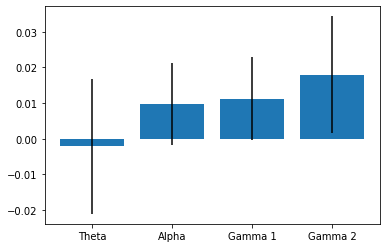

In [19]:
#Import additional packages
import matplotlib.pyplot as plt
import math

#Selecting 8 channels as bi-lateral parietal ROI
Ch = [17, 18, 19, 20, 54,55,56,57]

#Preallocate lists for each frequency band
SMETheta = []
SMEAlpha = []
SMEGamma1 = []
SMEGamma2 = []

#Loop over subjects
for i in list(range(0,4)):
    Thetatemp = []
    Alphatemp = []
    Gamma1temp = []
    Gamma2temp = []
    for k in Ch: 
        Thetatemp.append(SMEs[i][k][1])
        Alphatemp.append(SMEs[i][k][2])
        Gamma1temp.append(SMEs[i][k][3])
        Gamma2temp.append(SMEs[i][k][4])
    
    SMETheta.append(np.mean(Thetatemp))
    SMEAlpha.append(np.mean(Alphatemp))
    SMEGamma1.append(np.mean(Gamma1temp))   
    SMEGamma2.append(np.mean(Gamma2temp))
    
#Compute standard error
errTheta = np.std(SMETheta)/np.sqrt(len(SMETheta))
errAlpha = np.std(SMEAlpha)/np.sqrt(len(SMEAlpha))
errGamma1 = np.std(SMEGamma1)/np.sqrt(len(SMEGamma1))
errGamma2 = np.std(SMEGamma2)/np.sqrt(len(SMEGamma2))

#Plot it!
ax = plt.axes()
plt.bar(range(1,5), [np.mean(SMETheta), np.mean(SMEAlpha), np.mean(SMEGamma1), np.mean(SMEGamma2)],
        yerr = [errTheta, errAlpha, errGamma1, errGamma2])
plt.gca().set_xticks([1,2,3,4])
ax.set_xticklabels(['Theta', 'Alpha', 'Gamma 1', 'Gamma 2'])